# Fun with Census Data 

For a while, I've wanted to try doing some basic data analysis and visualizations in Python. So, I got some files from the 2010 US Census (available [here](https://www.census.gov/2010census/data/)). The data I worked with had some interesting facts about each state, going back every decade to 1910 (even states that weren't in the Union yet!). So I posed some questions and got to work.

In [10]:
import pandas as pd
import numpy as np
import math
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats

'''The population of each state at each decade, as well as the change from previous decade. 
X_POPULATION and X_CHANGE are the column names (X referring to a year ending with 10). 
There are these data for United States, Northeast, Midwest, South, West, 
Puerto Rico, and each individual state'''
pop_change_df = pd.read_csv('data/pop_change.csv', index_col=0, header=0, thousands=',')
pop_change_df.apply(pd.to_numeric)

'''The population density of each state. X_POPULATION, X_DENSITY, X_RANK are the keys'''
pop_density_df = pd.read_csv('data/pop_density.csv', index_col=0, header=0, skiprows=3, thousands=',')
pop_density_df.apply(pd.to_numeric)


'''The apportionment of representatives to the House by state. Keys include X_REPS,
X_PEOPLE_PER_REP, X_'''
apportionment_df = pd.read_csv('data/apportionment.csv', index_col=0, header=0, skiprows=1)
apportionment_df.apply(pd.to_numeric)
fix_nan_short = lambda num_or_nan: 0 if math.isnan(num_or_nan) else num_or_nan
zero_to_nan = lambda x: math.nan if (x==0) else x 

apportionment_df = apportionment_df.applymap(fix_nan_short)

'''For some reason, 1920 people per rep is a column of zeroes. We can fix that here by just calculating it.'''
apportionment_df['1920_PEOPLE_PER_REP'] = pop_change_df['1920_POPULATION']/apportionment_df['1920_REPS']
fix_inf = lambda num_or_inf: math.nan if math.isinf(num_or_inf) else num_or_inf #this definitely works 
apportionment_df['1920_PEOPLE_PER_REP'] = apportionment_df['1920_PEOPLE_PER_REP'].apply(fix_inf)

'''The dataframes, but only with states.'''
states_pop_change = pop_change_df.iloc[range(5, len(pop_change_df))]
states_pop_density = pop_density_df.iloc[range(1, len(pop_density_df))]
state_apportionment = apportionment_df.iloc[range(1, len(apportionment_df))]

'''Takes in a function which itself reads an integer value of a valid year ending in 10. 
Valid years are 1910, 1920, ..., 2010. Returns a dictionary whose keys are years and 
values are func(year) for those years all of these years.'''
def values_for_all_years(func): 
    return_dict = {}
    for i in range(11): 
        return_dict[1910 + (10 * i)] = func(1910 + (10 * i))
    return return_dict

def n_max(year, number, fast): 
    key = str(year) + '_CHANGE'
    if fast: 
        return states_pop_change[key].nlargest(n=number)
    else: 
        return states_pop_change[key].nsmallest(n=number)

## What things influence state population growth? 

### Population Size

**Question 1**: What things make a state's population grow from one decade to the next? ([1] Here, state population growth is measured as a percentage of the previous decade's. So, if Texas had $1,000$ residents in 1930 and $1,500$ in 1940, it's 1940 population change would be $0.5$). 

Does a state's size in one year affect its growth in the next? I could have gone either way on  this one. There's the 'social proof' case to be made for the positive relationship - maybe people want to move to big states like New York and California where lots of exciting things are happening. On the other hand, maybe people want to move to smaller states, which life is quieter and land is cheaper. 

What I wasn't expecting is that there's little relationship at all. For every year in the data set, I calculated the correlation between states' population size (the total number of people in the state) in one year, and its population growth percentage for the next decade. 

Correlation between the two is sometimes positive, sometimes negative, and the correlation coefficient ([2] I used [Pearson's r](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) never exceeds 0.25 in absolute value. Clearly, there's no relationship whatsoever.

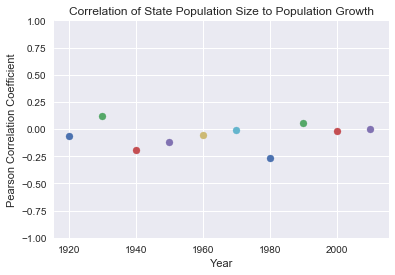

In [57]:
def corr_size_growth(initial_year): 
    size_key = str(initial_year) + '_POPULATION'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr_pvalue_tuple = stats.pearsonr(states_pop_change[size_key], states_pop_change[growth_key])
    plt.scatter(initial_year + 10, corr_pvalue_tuple[0])
    return corr_pvalue_tuple
fig = plt.subplot()
fig.set_xlabel('Year')
plt.title('Correlation of State Population Size to Population Growth')
plt.ylim(-1.0, 1.0)
plt.ylabel('Pearson Correlation Coefficient')
size_growth_correlations = [corr_size_growth(1910 + (x * 10)) for x in range(10)]

Even 1980, which showed the strongest relationship of all the years measured, had a p-value of $p \approx 0.054$ for its correlation - enough to reject the hypothesis that there was a relationship at a significance level of $0.05$.

### Population Density

**Question 1 (Revised):** Maybe we need to pose a a stricter question. The factors I appealed to for both the postive and negative case might make more sense if we measured population *density* (that is, number of people per square mile) instead of population  *growth*. A big state like California isn't exciting if you live in Central Valley - you need to be in one of the big cities, where a huge number of people live close to each other. And even if you live in a small state, you need fewer neighbors to ensure cheaper land and quieter life. 

So what about population density? Does the number of people per square mile in a state affect its population growth? Well, sometimes. If we do the same thing as before - calculating correlation between a state's population density in one year, and then its population growth in the next decade, here's what we get.

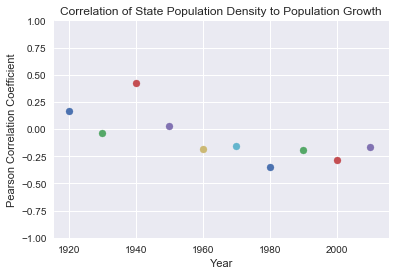

In [56]:
def corr_density_growth(initial_year): 
    density_key = str(initial_year) + '_DENSITY'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr_pvalue_tuple = stats.pearsonr(states_pop_density[density_key], states_pop_change[growth_key])
    plt.scatter(initial_year + 10, corr_pvalue_tuple[0])
    return corr_pvalue_tuple
fig = plt.subplot()
fig.set_xlabel('Year')
plt.title('Correlation of State Population Density to Population Growth')
plt.xlabel=('Year')
plt.ylabel('Pearson Correlation Coefficient')
plt.ylim(-1.0, 1.0)
density_growth_correlations = [corr_density_growth(1910 + (x * 10)) for x in range(10)]

# for x in range(10): 
#     if (density_growth_correlations[x][1] < 0.05):
#         print (str(1920 + (10 * x)) + ': ' + str(density_growth_correlations[x][1]) + '\n')
#print(pop_change_df['1940_CHANGE'].nsmallest(n=5))

We might be gettign a little warmer. There's been a weak negative correlation since 1960, meaning dense states grow slower than sparse ones. Interestingly, though, the decade with the largest correlation showed the opposite. What's up with population growth from 1930-1940, during which the correlation was $r \approx 0.436$, and p-value was $p \approx 0.001$? In short, the Dust Bowl. This was an absolutely massive inter-state migration of people - one of the most significant in American history. During the Dust Bowl, more than 3.5 million people emigrated from the Plain States to the West. In fact, the top 5 fastest-shriking states were all from the Great Plains (the Dakotas, Nebraska, Kansas, and Oklahoma). ([3] Source: https://en.wikipedia.org/wiki/Dust_Bowl).

But that's a story for another post. 

## People per Representative

Every census determines how many seats to the US House of Representatives each state gets. This is through a process called *apportionment*, which essentially gives every state one seat for free and then uses a legally specified formula to apportion the 51st seat, then the 52nd, and so on up to the 435th. ([4] These are called [priority values](https://www.census.gov/prod/cen2010/briefs/c2010br-08.pdf), which themselves have an interesting story). 

The people per representative has grown every decade, as the US population has more than doubled while the House has had 435 seats since 1930.

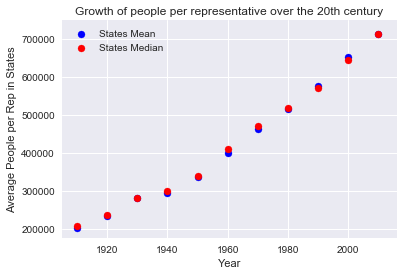

In [55]:
state_apportionment = state_apportionment.applymap(zero_to_nan)

corr_popsize_people_per_rep = (pop_2010.corr(people_per_rep_2010, method='pearson'))

mean_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].mean())
std_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].std())
median_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].median())

for year in mean_people_per_rep.keys(): 
    x1 = plt.scatter(year, mean_people_per_rep[year], color='blue') #mean is blue
    x2 = plt.scatter(year, median_people_per_rep[year], color='red') #mstatedian is red 
fig = plt.subplot()
fig.set_xlabel('Year')
plt.title('Growth of people per representative over the 20th century')
plt.ylabel('Average People per Rep in States')
plt.legend((x1, x2), ('States Mean', 'States Median'))
#so population has no correlation whatsoever with people per representative. 
#TODO: Data visualization here. X-axis can be size of population, and y-axis people per rep 
#TODO: Find out state trends in dilution of people per rep. 

So clearly, an individual's voting power has gotten diluted over time. Further, it's known that the [House is unequally representative](https://www.brookings.edu/blog/fixgov/2017/02/22/misrepresentation-in-the-house/), in part due to gerrymandering. This led to me asking if unequal representation in the House is also at an all-time high.

**Question 2: How bad are inter-state disparities in representation in the House right now? How do these compare to previous decade?** 

To measure this, I used the standard deviation in people per representative as a measure of the 'spread' in each decade. A perfectly fair year would have a standard deviation of $0$. 

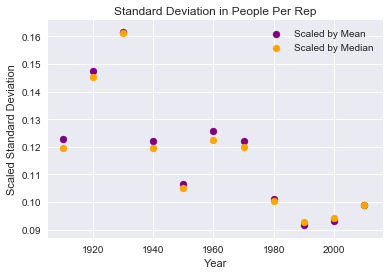

In [54]:
for year in std_people_per_rep.keys(): 
    z1 = plt.scatter(year, (std_people_per_rep[year])/(mean_people_per_rep[year]), color='purple')
    z2 = plt.scatter(year, (std_people_per_rep[year])/(median_people_per_rep[year]), color='orange')
fig = plt.subplot()
fig.set_xlabel('Year')
plt.title('Standard Deviation in People Per Rep')
plt.ylabel('Scaled Standard Deviation')
plt.legend((z1, z2), ('Scaled by Mean', 'Scaled by Median'))

As it turns out, by this measure things are much better in recent history than they had been in the past. This is not too surprising, as gerrymandering has been around for centuries. But I'm not going to conclude anything from this, since it's not really rigorous and it would be better to examine disparities district-by-district as opposed to a state level.

**Question 3: What states are best and worst-off in terms of people per representative?** The answer to this one might be a bit surprising. As a Californian, my first guess would have been that big states like CA and NY are worst-represented. But it turns out this isn't the case at all. States with large populations end up right in the middle. The states with both the highest and lowest values for People per Representative are relatively small. 

In [28]:
print(state_apportionment['2010_PEOPLE_PER_REP'].nlargest(n=5))
print(state_apportionment['2010_PEOPLE_PER_REP'].nsmallest(n=5))

STATE_OR_REGION
Montana         994416
Delaware        900877
South Dakota    819761
Idaho           786750
Oregon          769721
Name: 2010_PEOPLE_PER_REP, dtype: int64
STATE_OR_REGION
Rhode Island     527624
Wyoming          568300
Nebraska         610608
West Virginia    619938
Vermont          630337
Name: 2010_PEOPLE_PER_REP, dtype: int64


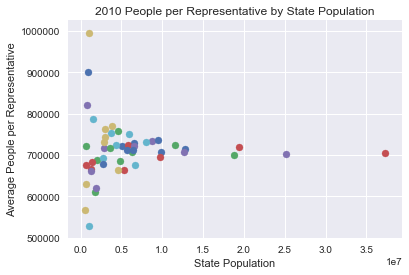

In [53]:
states = set.intersection(set(states_pop_change['2010_POPULATION'].index.values), 
                          set(state_apportionment['2010_PEOPLE_PER_REP'].index.values))

fig = plt.subplot()
for state in states: 
    plt.scatter(states_pop_change['2010_POPULATION'][state], state_apportionment['2010_PEOPLE_PER_REP'][state])
fig.set_xlabel('State Population')
plt.title('2010 People per Representative by State Population')
plt.ylabel('Average People per Representative')